## Описание проекта

Служба такси собрала исторические данные о заказах в аэропортах. Для того чтобы привлекать остаточное число таксистов в периоды пиковой нагрузки, требуется обучить модель для предсказания количества заказов на следующий час.


### План решения задачи

* [1. Загрузка и подготовка данных](#1-bullet)
* [2. Анализ данных](#2-bullet)
* [3. Обучение моделей](#3-bullet)
* [4. Тест моделей](#4-bullet)

In [124]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from xgboost.sklearn import XGBRegressor

import statsmodels.tsa.api as smt
import statsmodels.api as sm


from xgboost import plot_importance, plot_tree

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings('ignore')

# 1. Загрузка и подготовка данных <a id='1-bullet'></a>

In [93]:
df = pd.read_csv('taxi.csv', index_col=['datetime'], parse_dates=['datetime'], dayfirst=True)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Для анализа и построения моделей нам необходимо отсортировать данные и провести ресемплинг по одному часу

<AxesSubplot:xlabel='datetime'>

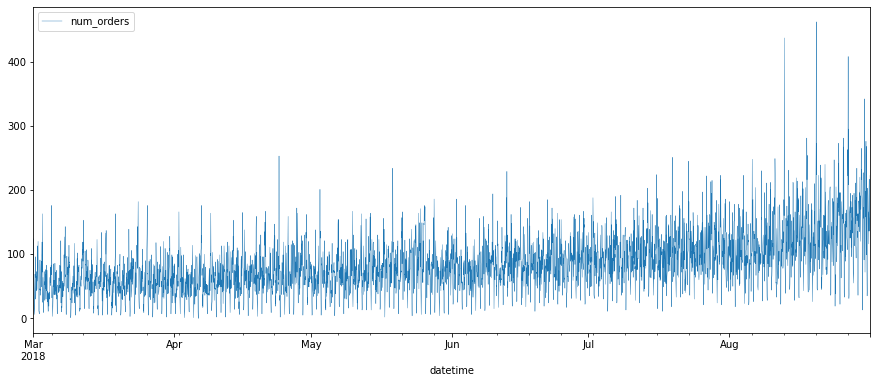

In [95]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()
df.plot(figsize=(15,6), linewidth=0.4)

На графике присутствуют выбросы, которые влияют на разброс значений, и заметен восходящий тренд - со временем услугами такси пользуется все большое число людей.

# 2. Анализ данных <a id='2-bullet'></a>

Разложим временной ряд на части ( тренд и сезонность) и изучим несколько временных рядов.

Для удобства напишим функцию.

In [96]:
decomposed = seasonal_decompose(df)

def graph_decomp(time1, time2):
    plt.figure(figsize=(12, 5))

    plt.subplot(121)
    decomposed.trend[time1:time2].plot(ax=plt.gca(), grid=True)
    plt.title('Trend')

    plt.subplot(122)
    decomposed.seasonal[time1:time2].plot(ax=plt.gca())
    plt.title('Seasonality')

    plt.tight_layout()

In [97]:
df.index.min(), df.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

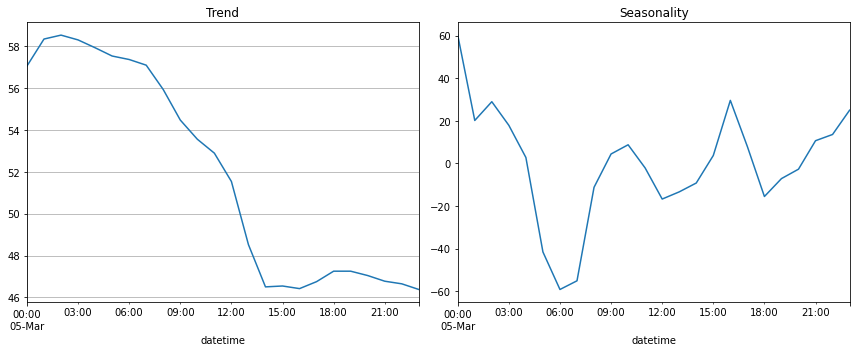

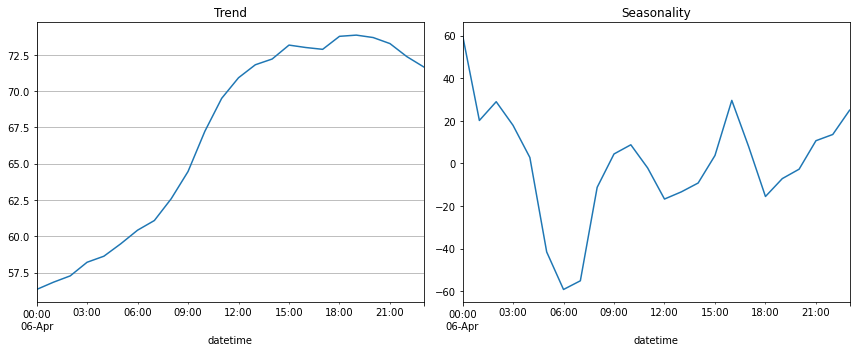

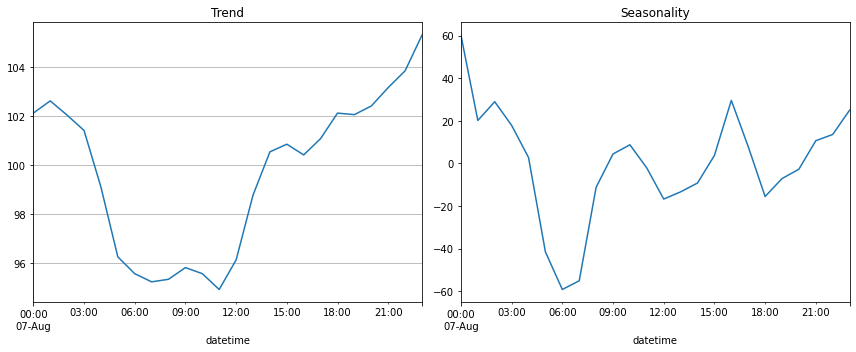

In [98]:
# случайные дни

graph_decomp('2018-03-05', '2018-03-05')
graph_decomp('2018-04-06', '2018-04-06')
graph_decomp('2018-08-07', '2018-08-07')

Явно присутствует сезонность: в 6 утра спрос на услуги такси маленький, а то время как днем он увеличивается. Можно выделить два пика: в начале рабочего дня и в его конце, когда люди склонны перемещаться по городу чаще всего.

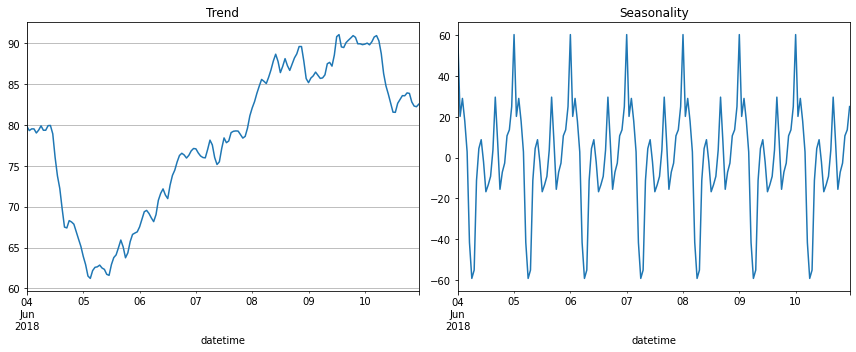

In [125]:
# посмотрим на недельные значения

graph_decomp('2018-06-04', '2018-06-10')

Сезонность никак не изменилась - одна и таже картина каждый день. При этом, можно отметить тренд на увеличение заказов в последние дни недели (с пятницы по воскресение). График строился с понедельника по воскресение.

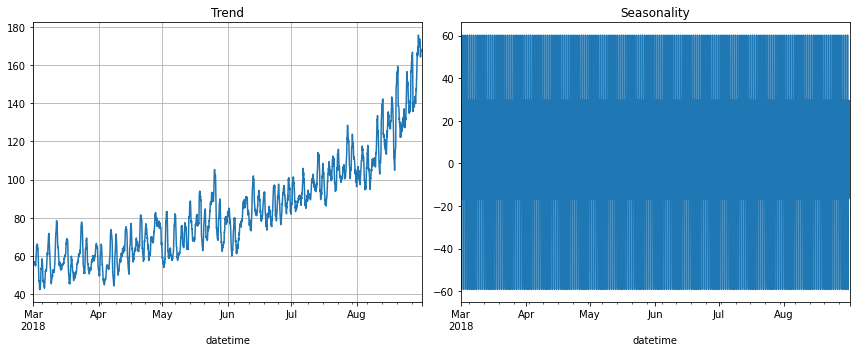

In [100]:
# теперь за все время

graph_decomp('2018-03-01', '2018-08-31')

Предположение о наличии восходящего тренда по заказам такси подтвердилось.

# 3. Обучение моделей <a id='3-bullet'></a>

Для начала добавим новые признаки:
- hour — нам важно проанализировать часовые значения
- weekday — кол-во заказов может меняться в зависимости от дня
- отстающие значения — чтобы учесть предыдущие значения. они довольно долго подбирались для хорошего результата
- скользящее среднее — модели полезно знать общий тренд 

In [101]:
df_new = df.copy()

df_new["hour"] = df_new.index.hour
df_new["weekday"] = df_new.index.dayofweek
df_new['rolling_mean'] = df_new['num_orders'].shift().rolling(3).mean() # скользящее среднее
    
for lag in range(1, 24+1):
    df_new['lag_{}'.format(lag)] = df_new['num_orders'].shift(lag) # отстающие значения
    
df_new = df_new.dropna()
    
df_new.head()

,num_orders,hour,weekday,rolling_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,0,4,79.000000,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-02 01:00:00,120,1,4,87.000000,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-02 02:00:00,75,2,4,89.333333,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-02 03:00:00,64,3,4,95.000000,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-02 04:00:00,20,4,4,86.333333,64.0,75.0,120.0,90.0,58.0,113.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


Разделим выборку на train и test

In [102]:
train, test = train_test_split(df_new, shuffle=False, test_size=0.1)

X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3952, 27), (3952,), (440, 27), (440,))

## Поработаем с тремя алгоритмами: LinearRegression, XGBoost и ARIMA

### LinearRegression

In [103]:
model_reg = LinearRegression()
model_reg.fit(X_train, y_train)

predicted_train_reg = model_reg.predict(X_train)
rmse_train_reg = rmse(y_train, predicted_train_reg)

print("RMSE на обучающей выборке:", rmse_train_reg)

RMSE на обучающей выборке: 25.84476620987006


<AxesSubplot:xlabel='datetime'>

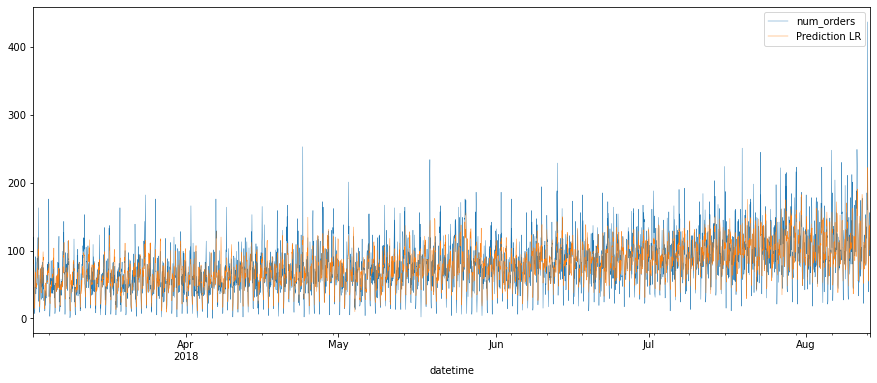

In [104]:
pd.concat([y_train, pd.DataFrame(predicted_train_reg, index = y_train.index, columns=['Prediction LR'])]
          , axis=1).plot(figsize=(15,6), linewidth=0.4)

На обучающих данных все выглядит неплохо - чуть позже проверим на тестовых. 

### XGBoost

In [105]:
xgb_model = XGBRegressor(n_estimators=100, random_state=17, silent=True)
param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'objective': ['reg:squarederror']
    }

gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring = 'neg_mean_squared_error',
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

gsearch.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   28.7s finished


[18:37:01] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, silent=True,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
  

In [106]:
display(gsearch.best_params_)

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 5,
 'objective': 'reg:squarederror',
 'subsample': 0.7}

In [107]:
predicted_train_xgb = gsearch.predict(X_train)
rmse_train_xgb = rmse(y_train, predicted_train_xgb)
print("RMSE на обучающей выборке:", rmse_train_xgb)

RMSE на обучающей выборке: 15.292720185204066


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

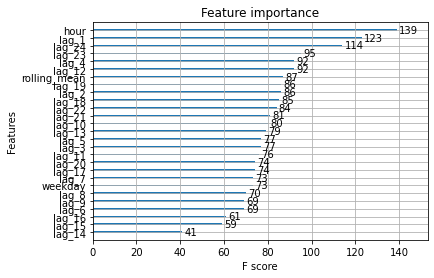

In [108]:
plot_importance(gsearch.best_estimator_)

"Деревянная" модель показала себя на обучающей выборке лучше чем линейная регрессия. Главным образом она сфокусировалась на часовых данных и отстающих значениях.

### ARIMA

Попробуем использовать алгоритм, который "заточен" под анализ времянных рядов. Подберем параметры с помощью auto_arima().

In [109]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [110]:
model = auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # использовать adftest для поиска оптимального 'd'
                      max_p=3, max_q=3, # максимальное p и q
                      m=1,              
                      d=1,           
                      seasonal=True,    # у нас присутствует явная сезонность
                      start_P=0,  
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39785.522, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39407.923, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39248.315, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39783.522, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=39246.314, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=39405.923, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.71 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.118 seconds


In [116]:
model.fit(train)

predicted_arima_train = model.predict(n_periods=len(train))
predicted_arima_train = pd.DataFrame(predicted_arima_train, index = train.index,columns=['Prediction'])

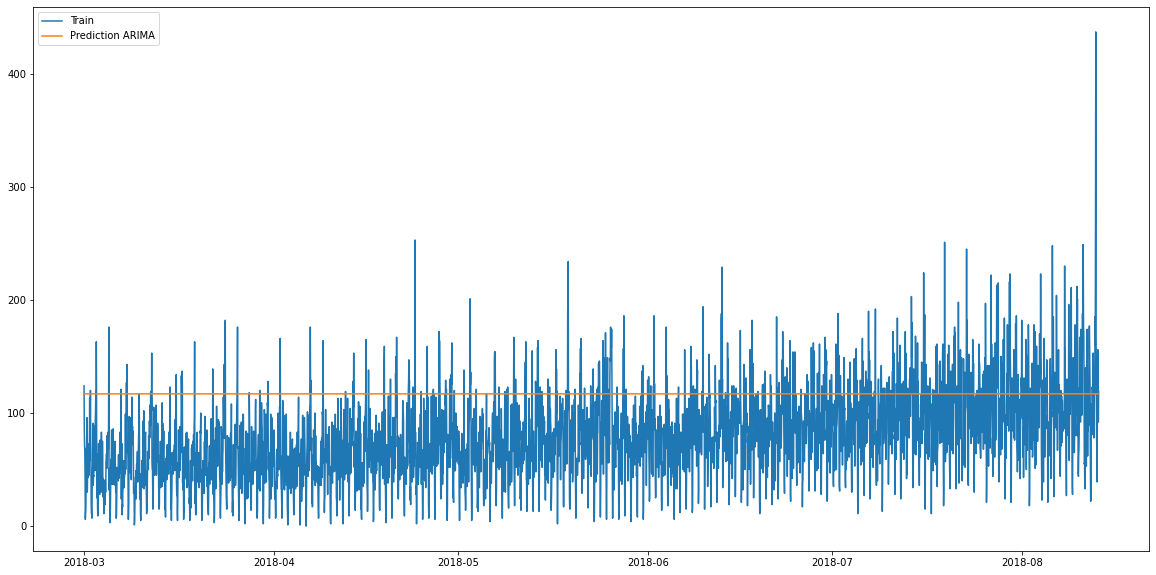

In [112]:
ig, ax = plt.subplots(figsize=(20, 10))

plt.plot(train, label='Train')
plt.plot(train_forecast_arima, label='Prediction ARIMA')
plt.legend(loc="upper left")
plt.show()

In [113]:
rmse_train_arima = rmse(train, train_forecast_arima)
print('RMSE на обучающей выборке:', rmse_train_arima)

RMSE на обучающей выборке: [54.6666966]


Здесь конечно требуется более тщательный подбор гиперпараметров. В нашем случае эта модель показала самый слабый результат, который годится разве что в качестве проверки итоговой модели на адекватность.

# 4. Тестирование моделей <a id='4-bullet'></a>

### LinearRegression

RMSE тестовой выборки:  45.22409490531759


<AxesSubplot:xlabel='datetime'>

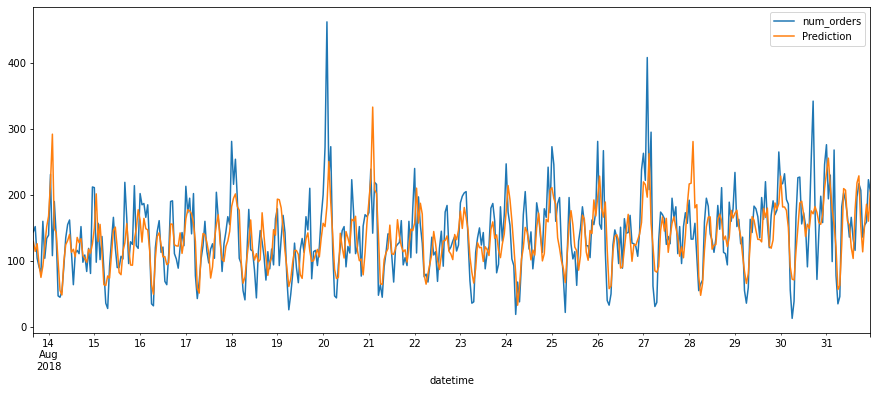

In [114]:
pred_test_reg = model_reg.predict(X_test)
rmse_test_reg = rmse(y_test, pred_test_reg)
print("RMSE тестовой выборки: ", rmse_test_reg)

pred_test_reg_graph = pd.DataFrame(pred_test_reg, index = y_test.index,columns=['Prediction'])
pd.concat([y_test, pred_test_reg_graph],axis=1).plot(figsize=(15,6))

### XGBoost

RMSE на тестовой выборке: 39.774952673549286


<AxesSubplot:xlabel='datetime'>

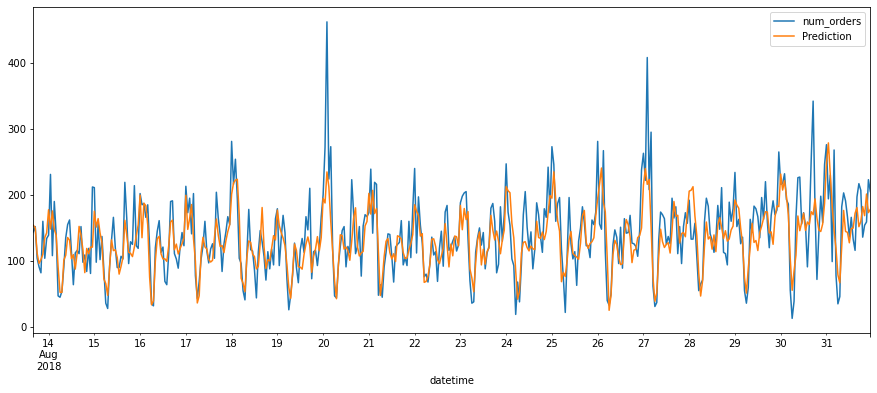

In [115]:
pred_test_xgb = gsearch.predict(X_test)
xgb_test_rmse = rmse(y_test, pred_test_xgb)
print('RMSE на тестовой выборке:', xgb_test_rmse)

pred_test_xgb_graph = pd.DataFrame(pred_test_xgb, index = y_test.index,columns=['Prediction'])
pd.concat([y_test, pred_test_xgb_graph],axis=1).plot(figsize=(15,6))

### ARIMA

RMSE на обучающей выборке: [54.6666966]


<AxesSubplot:xlabel='datetime'>

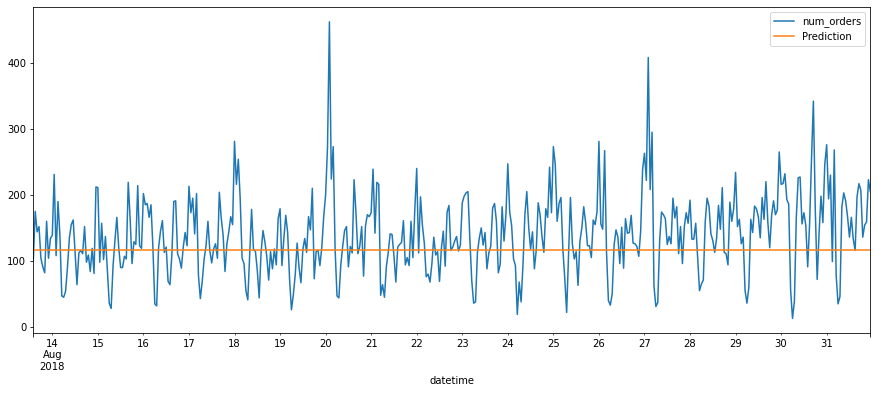

In [123]:
predicted_arima_test = model.predict(n_periods=len(test))
rmse_test_arima = rmse(test, predicted_arima_test)
print('RMSE на обучающей выборке:', rmse_train_arima)

pred_test_arima_graph = pd.DataFrame(predicted_arima_test, index = test.index,columns=['Prediction'])
pd.concat([test, pred_test_arima_graph],axis=1).plot(figsize=(15,6))

### Вывод

Лучше всего себя показал XGBoost: RMSE на тестовой выборке равна 39.77. Второй результат показала Линейная регрессия: RMSE на тестовой выборке равна 45.22. Хуже всего дела у ARIMA, но я еще вернусь к этому алгоритму и постараюсь "добить" его. 

Буду очень благодарен если тов. Ревьюер подскажет материалы на тему анализа временных рядов :)